In [2]:
import torch
from torchvision import transforms, models
import numpy as np
import os
from PIL import Image
import pickle

Cargar Datos

In [4]:
!wget https://www.dropbox.com/scl/fi/zitvonlp9rlg6b0tzte7t/homy_eval.zip?rlkey=1w67q18zjpimyec3i6wm3u5bf -O homy.zip


--2025-07-29 13:42:46--  https://www.dropbox.com/scl/fi/zitvonlp9rlg6b0tzte7t/homy_eval.zip?rlkey=1w67q18zjpimyec3i6wm3u5bf
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc07d2c4bae852efb68dca383640.dl.dropboxusercontent.com/cd/0/inline/Cua2-ebFPEd3Q419NjVK7YW09Sw-8CZxt1bNzCiXe6laTV3i7qJteu5hLl1FM1bGfFGXFQaJw_tjgpzBRSmh1sCb5R1xHNodRH090eK0LzEed7fbMHrO1ZR8Bt-lTjY3Tnz6C1ePUsXW-B8fbP5I4x2t/file# [following]
--2025-07-29 13:42:47--  https://uc07d2c4bae852efb68dca383640.dl.dropboxusercontent.com/cd/0/inline/Cua2-ebFPEd3Q419NjVK7YW09Sw-8CZxt1bNzCiXe6laTV3i7qJteu5hLl1FM1bGfFGXFQaJw_tjgpzBRSmh1sCb5R1xHNodRH090eK0LzEed7fbMHrO1ZR8Bt-lTjY3Tnz6C1ePUsXW-B8fbP5I4x2t/file
Resolving uc07d2c4bae852efb68dca383640.dl.dropboxusercontent.com (uc07d2c4bae852efb68dca383640.dl.dropboxusercontent.com)... 162.125.5.15, 2620:

In [7]:
!unzip homy.zip

Archive:  homy.zip
replace homy_eval/eval/ph00108.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# cargar DinoV2

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# load the model (dinov2->vector size 368)
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)


Using device: cpu


Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 239MB/s]


In [8]:
# Definimos las transformaciones para la imagen
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
    ])

def compute_embeddings(lfiles) :
    n = len(lfiles)
    dim = 384
    features = np.zeros((n, dim), dtype = np.float32)
    with torch.no_grad():
        for i, ifile in enumerate(lfiles) :
            image = Image.open(ifile).convert('RGB')
            image = preprocess(image).unsqueeze(0).to(device)
            features[i,:] = model(image).cpu()[0,:]
            if i%10 == 0 :
                print('{}/{}'.format(i, n))
    return features

In [9]:
data_dir = '/content/homy_eval'
fdata = os.path.join(data_dir, 'eval.txt')
lfiles = []
with open(fdata) as f:
    for ifile in f :
        ifile = os.path.join(data_dir, ifile.strip())
        lfiles.append(ifile)
features = compute_embeddings(lfiles)
print(features.shape)


/tmp/ipython-input-8-1322127173.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  features[i,:] = model(image).cpu()[0,:]


0/255
10/255
20/255
30/255
40/255
50/255
60/255
70/255
80/255
90/255
100/255
110/255
120/255
130/255
140/255
150/255
160/255
170/255
180/255
190/255
200/255
210/255
220/255
230/255
240/255
250/255
(255, 384)


In [10]:
with open('dinov2_homy.pk', 'wb') as f:
    pickle.dump(lfiles, f)
np.save("dinov2_homy_feats.npy", features)
print('saving data ok')

saving data ok


Comparar todo contra todos

In [11]:
lfiles = []
with open('dinov2_homy.pk', 'rb') as f:
    lfiles =pickle.load(f)
print(lfiles)

['/content/homy_eval/eval/ph00118.jpg', '/content/homy_eval/eval/ph00238.jpg', '/content/homy_eval/eval/ph00217.jpg', '/content/homy_eval/eval/ph00171.jpg', '/content/homy_eval/eval/ph00181.jpg', '/content/homy_eval/eval/ph00197.jpg', '/content/homy_eval/eval/ph00138.jpg', '/content/homy_eval/eval/ph00055.jpg', '/content/homy_eval/eval/ph00020.jpg', '/content/homy_eval/eval/ph00120.jpg', '/content/homy_eval/eval/ph00153.jpg', '/content/homy_eval/eval/ph00008.jpg', '/content/homy_eval/eval/ph00053.jpg', '/content/homy_eval/eval/ph00157.jpg', '/content/homy_eval/eval/ph00168.jpg', '/content/homy_eval/eval/ph00237.jpg', '/content/homy_eval/eval/ph00049.jpg', '/content/homy_eval/eval/ph00032.jpg', '/content/homy_eval/eval/ph00148.jpg', '/content/homy_eval/eval/ph00182.jpg', '/content/homy_eval/eval/ph00051.jpg', '/content/homy_eval/eval/ph00275.jpg', '/content/homy_eval/eval/ph00244.jpg', '/content/homy_eval/eval/ph00185.jpg', '/content/homy_eval/eval/ph00094.jpg', '/content/homy_eval/eval

In [12]:
features = np.load("dinov2_homy_feats.npy")
print(features.shape)


(255, 384)


Calcular similitud coseno

In [50]:
norm2 = np.linalg.norm(features, ord = 2, keepdims = True)
feats_norm = features / norm2
sim = feats_norm @ np.transpose(feats_norm)
sim_idx = np.argsort(-sim, axis = 1)
print(sim.shape)

(255, 255)


Visualizar Resultados

In [51]:
import matplotlib.pyplot as plt

51


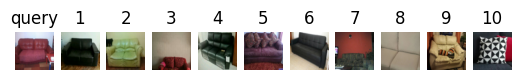

In [52]:
idx_query = np.random.randint(len(lfiles))
print(idx_query)
k = 10
best_idx = sim_idx[idx_query, :k + 1]
fig, ax = plt.subplots(1, k +1)
for i in range(k + 1) :
  ax[i].set_title(str(i))
  ax[i].set_axis_off()
ax[0].set_title('query')
isize = 64
for i, idx in enumerate(best_idx) :
  image = Image.open(lfiles[idx]).convert('RGB')
  image = image.resize((isize,isize))
  ax[i].imshow(np.asarray(image))
plt.show()